# Relatedness and Population structure

## 5.1 Genetic Relatedness

### 5.1.2 Estimating relatedness

##### Example 5.1

In [1]:
offspring.geno <- function(n.families, n.snps, fs=rep(0.50, n.snps), n.shared.parents=2) {
    # INPUT:
    #   n.families, number of families where each family produces two offspring (>0)
    #   n.snps, number of independent SNPs used in simulation (>0)
    #   fs, vector of allele 1 freqs for SNPs, length == n.snps, values >0 & <1
    #   n.shared.parents, 0, 1, 2 shared parents for the two offspring in each family
    # OUTPUT:
    #   X, genotypes of (2*n.families) offspring, (2*n.families) x n.snps matrix with 0, 1, 2 entries
    
    stopifnot(n.families > 0)
    stopifnot(n.snps > 0)
    stopifnot(all(fs>0 & fs<1) & length(fs)==n.snps)
    stopifnot(n.shared.parents %in% 0:2)
    
    if(n.shared.parents==2) parents = list(c(1, 2), c(1, 2))
    if(n.shared.parents==1) parents = list(c(1, 2), c(3, 2))
    if(n.shared.parents==0) parents = list(c(1, 2), c(3, 4))
    n.parents = 4 - n.shared.parents
    
    X = matrix(0, nrow=2*n.families, ncol=n.snps)
    for(ii in 1:n.families) {
        # each family means a pair of offsprings that share 'n.shared.parents'
        x.parents = t(replicate(2*n.parents, rbinom(n.snps, size=1, prob=fs)))
        for(offs in 1:2) { # for two offspring within "family"
            # phase is the indicator that whether offs inherit each parents first allele or not
            phase = t(replicate(2, rbinom(n.snps, size=1, prob=0.50))) # phase has one row for each parent
            for(i.parent in 1:2) {
                for(ph in 0:1) {
                    loci = (phase[i.parent,] == ph) # which loci from i.parent have phase ph?
                    # add to the current offs' genotype i.parent's allele from the correct phase
                    X[2*(ii-1) + offs, loci] = X[2*(ii-1) + offs, loci] + x.parents[2*parents[[offs]][i.parent] - ph, loci]
                }
            }
        }
    }
    return (X)
}

In [2]:
p = 10000 # SNPs
fs = runif(p, 0.2, 0.5) # MAF at each SNP is Uniform(0.2, 0.5)

X = rbind(
    offspring.geno(n.families=5, n.snps=p, fs=fs, n.shared.parents=0),
    offspring.geno(n.families=5, n.snps=p, fs=fs, n.shared.parents=1),
    offspring.geno(n.families=5, n.snps=p, fs=fs, n.shared.parents=2)
)

X = X[,apply(X, 2, var)>0] # remove possible monomorphic variants

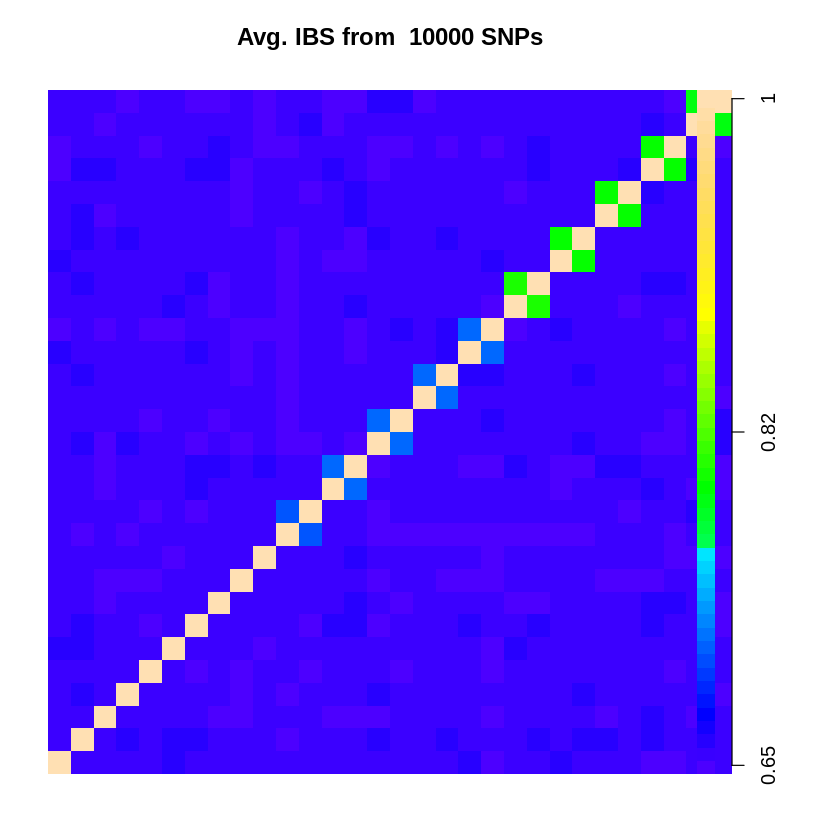

In [3]:
n.cols = 50 # number of colors
IBS.2 = ((X==2) %*% t(X==2) + (X==1) %*% t(X==1) + (X==0) %*% t(X==0)) / p
IBS.1 = ((X==1) %*% t(X==0|X==2) + (X==0|X==2) %*% t(X==1)) / p
IBS = IBS.2 + 0.50 * IBS.1 # proportion of genome IBS
layout(matrix(c(1, 2), nrow=1), width=c(9, 1)) # plotting area divided into 9/10 and 1/10 wide regions
par(mar=c(2, 2, 3, 1)) # plot IBS matrix using image
image(IBS, col=topo.colors(n.cols), breaks=seq(min(IBS), max(IBS), length=n.cols+1),
     asp=1, xaxt="n", yaxt="n", bty="n",
     main=paste("Avg. IBS from ", ncol(X), "SNPs"))
par(mar=c(2, 1, 3, 1)) # plot scale for colors
plot.window(xlim=c(0, 1), ylim=c(0, n.cols))
points(x=rep(1, n.cols+1), y=(0:n.cols), col=topo.colors(n.cols+1), pch=15, cex=2)
axis(4, at=c(0, n.cols/2, n.cols),
    labels=c(round(min(IBS), 2), round((min(IBS) + max(IBS))/2, 2), round(max(IBS), 2)))

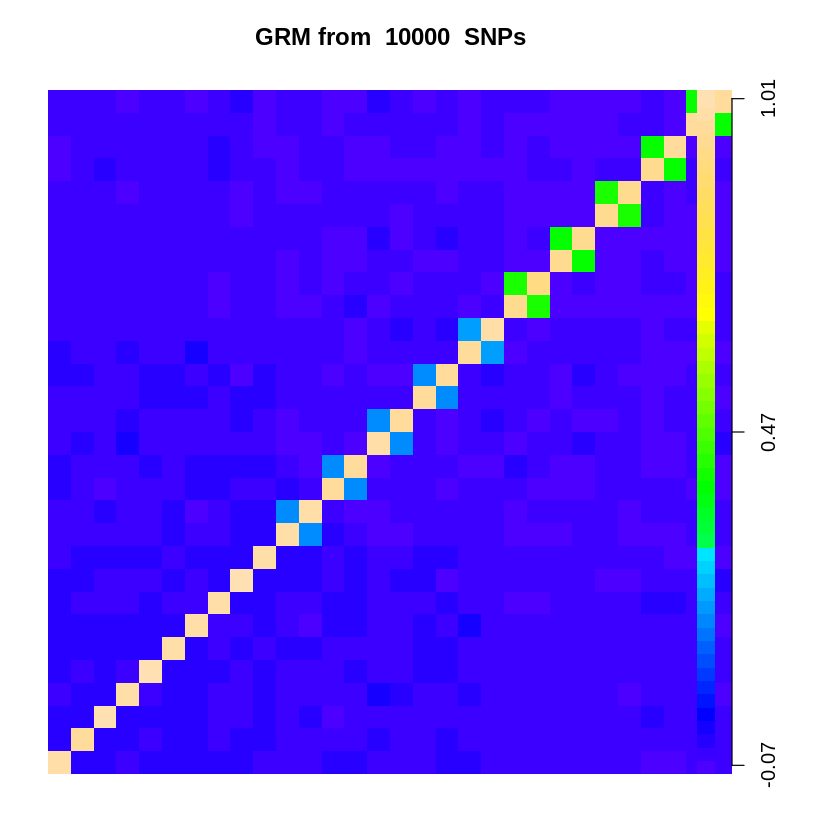

In [4]:
X.scaled = scale(X) # standardize each SNP at columns of X
GRM = (X.scaled %*% t(X.scaled)) / p # correlation matrix of individuals based on standardized SNPs

layout(matrix(c(1, 2), nrow=1), width=c(9, 1))
par(mar=c(2, 2, 3, 1)) # margins for matrix
image(GRM, col=topo.colors(n.cols), breaks=seq(min(GRM), max(GRM), length=n.cols+1),
     asp=1, xaxt="n", yaxt="n", bty="n",
     main=paste("GRM from ", ncol(X), " SNPs"))
par(mar=c(2, 1, 3, 1)) # margins for scale
plot.window(xlim=c(0, 1), ylim=c(0, n.cols))
points(x=rep(1, n.cols+1), y=(0:n.cols), col=topo.colors(n.cols+1), pch=15, cex=2)
axis(4, at=c(0, n.cols/2, n.cols),
    labels=c(round(min(GRM), 2), round((min(GRM)+max(GRM))/2, 2), round(max(GRM), 2)) )

In [5]:
full.sibs = which(GRM>0.40 & GRM<0.60, arr.ind=T) # each pair twice since R is symmetric
full.sibs = full.sibs[full.sibs[,1] < full.sibs[,2]] # pick only pairs where first index is less than second index
rbind(full=as.vector(t(full.sibs)))

full,21,23,25,27,29,22,24,26,28,30


In [6]:
half.sibs = which(GRM>0.15 & GRM<0.35, arr.ind=T)
half.sibs = half.sibs[half.sibs[,1] < half.sibs[,2]]
rbind(half=as.vector(t(half.sibs)))

half,11,13,15,17,19,12,14,16,18,20


##### KING

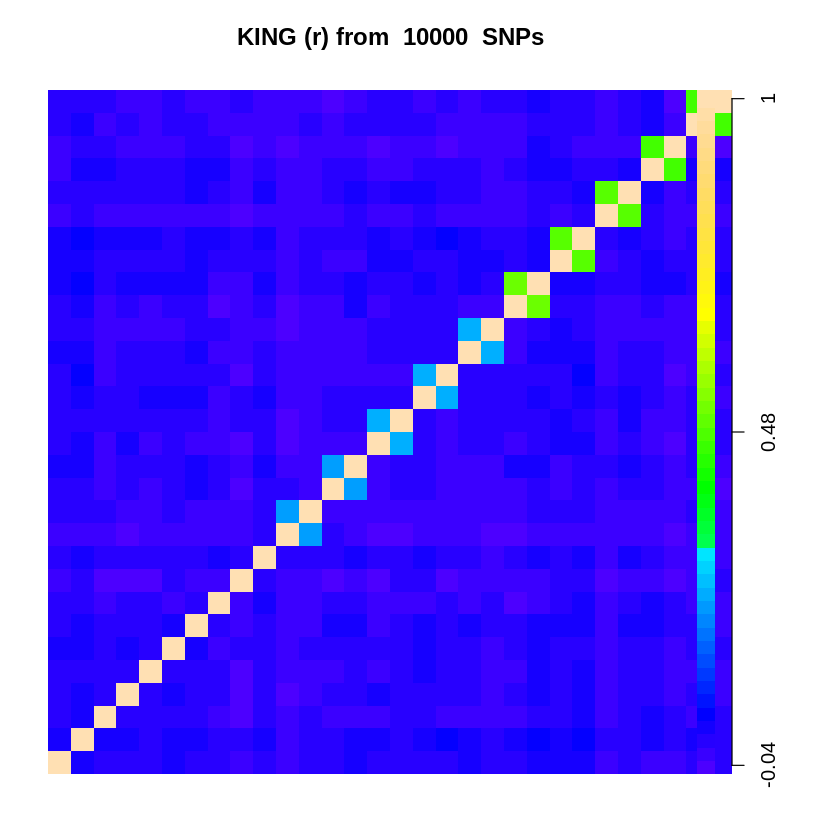

In [7]:
denominator = matrix(rep(rowSums(X==1), nrow(X)), nrow=nrow(X), byrow=T) +
              matrix(rep(rowSums(X==1), nrow(X)), nrow=nrow(X), byrow=F)
king.r = 2*((X==1) %*% t(X==1) - 2*((X==0) %*% t(X==2) + (X==2) %*% t(X==0))) / denominator

layout(matrix(c(1, 2), nrow=1), width=c(9, 1))
par(mar=c(2, 2, 3, 1)) # margins for matrix
image(king.r, col=topo.colors(n.cols), breaks=seq(min(king.r), max(king.r), length=n.cols+1),
     asp=1, xaxt="n", yaxt="n", bty="n",
     main=paste("KING (r) from ", ncol(X), " SNPs"))
par(mar=c(2, 1, 3, 1)) # margins for scale
plot.window(xlim=c(0, 1), ylim=c(0, n.cols))
points(x=rep(1, n.cols+1), y=(0:n.cols), col=topo.colors(n.cols+1), pch=15, cex=2)
axis(4, at=c(0, n.cols/2, n.cols),
    labels=c(round(min(king.r), 2), round((min(king.r)+max(king.r))/2, 2), round(max(king.r), 2)) )

## 5.2 Population Structure

### 5.2.1 Sources of population structure

##### Example 5.2 Genetic Drift

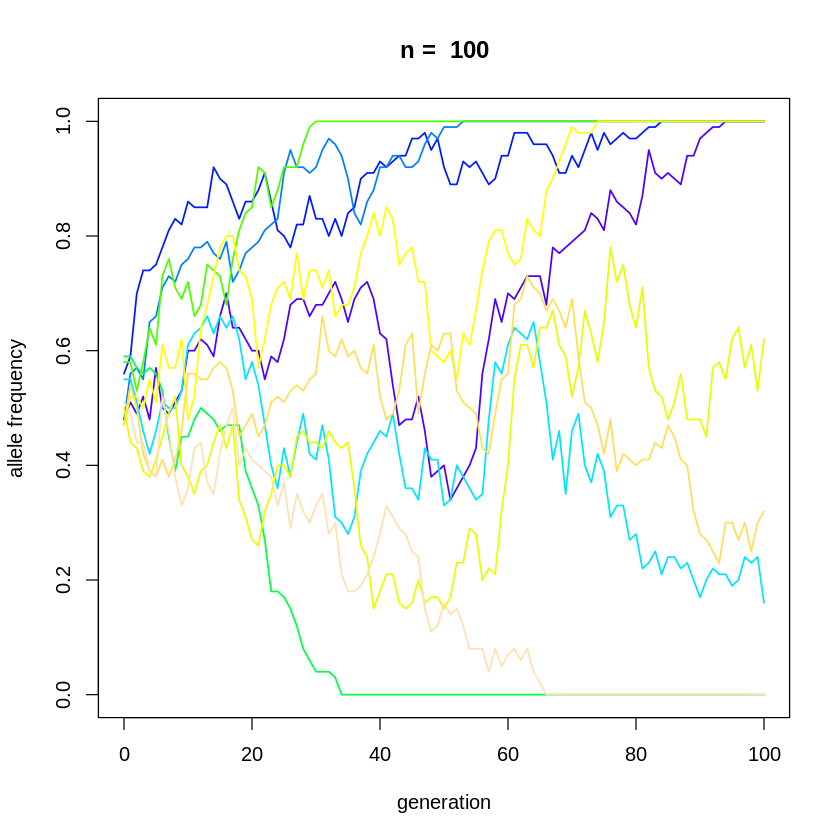

In [8]:
n = 100 # alleles in each generation of each subpopulation
f0 = 0.50 # starting allele frequency
K = 100 # number of generations in simulation
npop = 10 # Let's make 10 rather than just 2 pops to illustrate more general behavior
f = matrix(NA, ncol=K+1, nrow=npop) # results of allel freqs across pops and generations
for(pop in 1:npop) {
    a = rbinom(n, 1, f0) # starting configuration of alleles
    f[pop, 1] = mean(a) # allele frequency at generation 0
    for(ii in 1:K) {
        a = sample(a, size=n, replace=T) # resample generation ii
        f[pop, ii+1] = mean(a) # allele frequency at generation ii (index ii+1 since generation 0 is at index 1)
    }
}
plot(NULL, xlab="generation", ylab="allele frequency",
    main=paste("n = ", n), xlim=c(0, K), ylim=c(0, 1))
for(pop in 1:npop) {
    lines(0:K, f[pop,], lwd=1.4, col=topo.colors(npop)[pop])
}

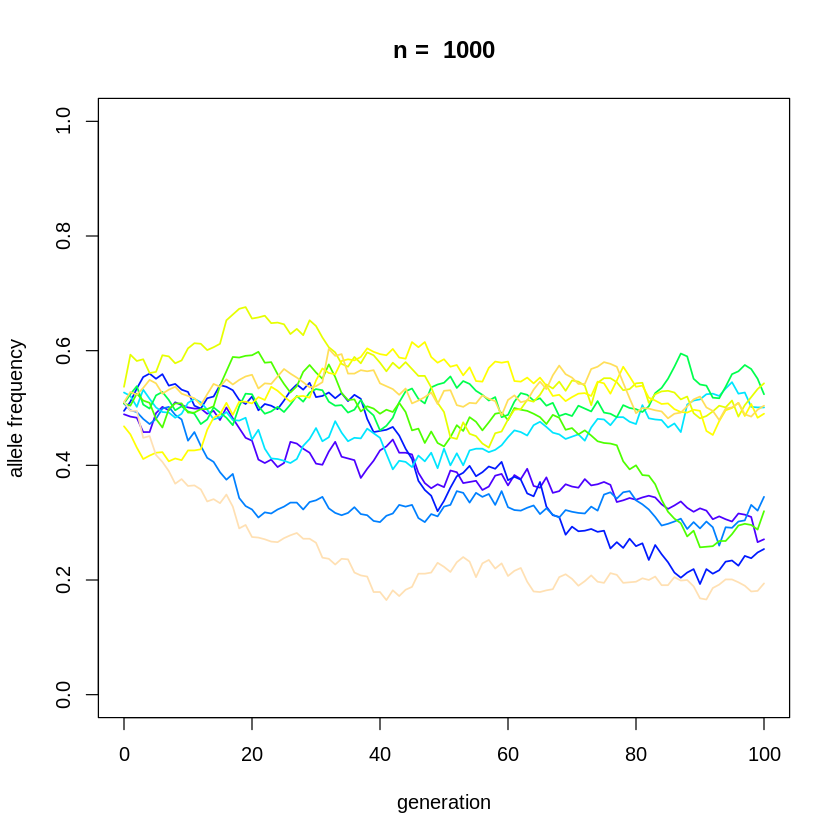

In [9]:
n = 1000 # alleles in each generation of each subpopulation
f0 = 0.50 # starting allele frequency
K = 100 # number of generations in simulation
npop = 10 # Let's make 10 rather than just 2 pops to illustrate more general behavior
f = matrix(NA, ncol=K+1, nrow=npop) # results of allel freqs across pops and generations
for(pop in 1:npop) {
    a = rbinom(n, 1, f0) # starting configuration of alleles
    f[pop, 1] = mean(a) # allele frequency at generation 0
    for(ii in 1:K) {
        a = sample(a, size=n, replace=T) # resample generation ii
        f[pop, ii+1] = mean(a) # allele frequency at generation ii (index ii+1 since generation 0 is at index 1)
    }
}
plot(NULL, xlab="generation", ylab="allele frequency",
    main=paste("n = ", n), xlim=c(0, K), ylim=c(0, 1))
for(pop in 1:npop) {
    lines(0:K, f[pop,], lwd=1.4, col=topo.colors(npop)[pop])
}

### 5.2.2 Pricipal component analysis (PCA)

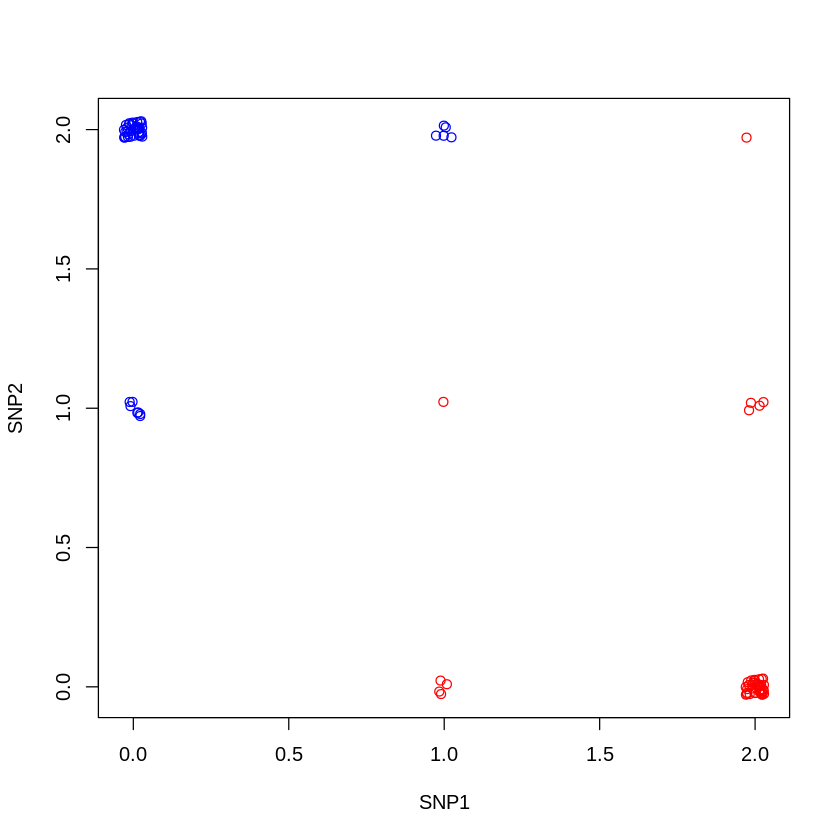

In [10]:
set.seed(20)
npop = 2
cols = c("blue", "red")
f = matrix(c(0.05, 0.95, 0.95, 0.05), byrow=T, ncol=npop)
p = nrow(f) #  number of SNPs
n = rep(50, npop) # number of samples from each population
pop = rep(1:npop, n) # from which population each individual comes
X = c() # empty genotype data matrix
for(ii in 1:p) {
    x = c() # empty genotype vector for SNP ii
    for(jj in 1:npop) {
        x = c(x, rbinom(n[jj], size=2, f[ii, jj])) # add genotypes of pop jj to x
    }
    X = cbind(X, x) # add SNP x as a new column to genotype matrix X
}
jitt.1 = runif(n[1], -0.03, +0.03) # add some noise to coordinates in plot to avoid overlap
jitt.2 = runif(n[2], -0.03, +0.03)
plot(X[,1] + jitt.1, X[,2] + jitt.2, col=cols[pop], xlab="SNP1", ylab="SNP2")

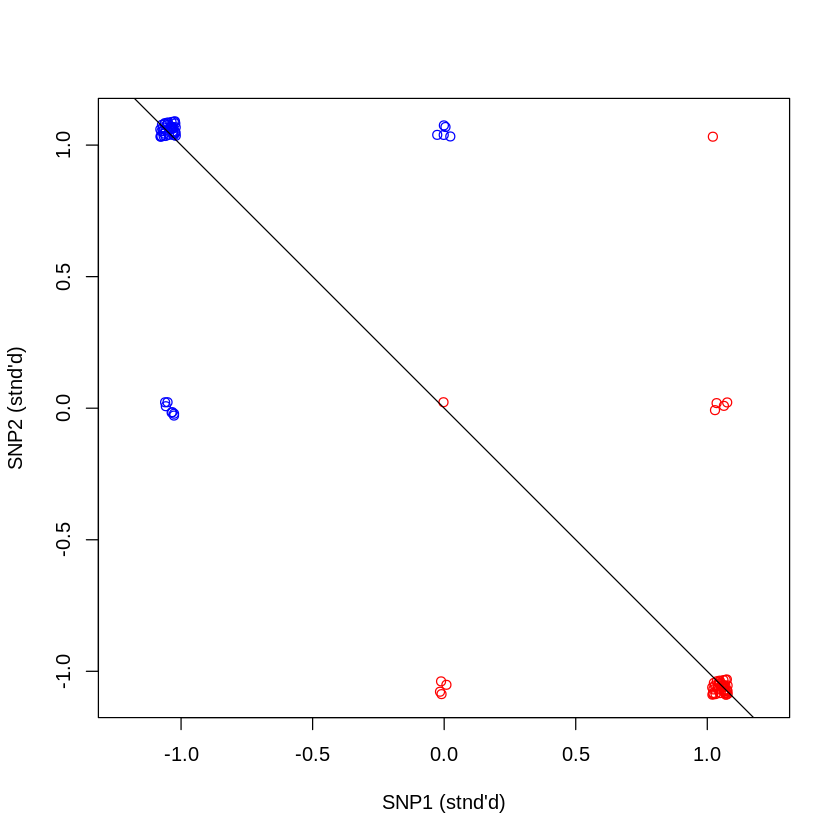

In [11]:
X = scale(X) # always standardize each variant  before PCA
pca = prcomp(X) # do PCA
plot(X[,1] + jitt.1, X[,2] + jitt.2, asp=1, # Plot the points, now after scaling
    col=cols[pop], xlab="SNP1 (stnd'd)", ylab="SNP2 (stnd'd)")
abline(a=0, b=pca$rotation[2, 1] / pca$rotation[1, 1]) # add PCA line

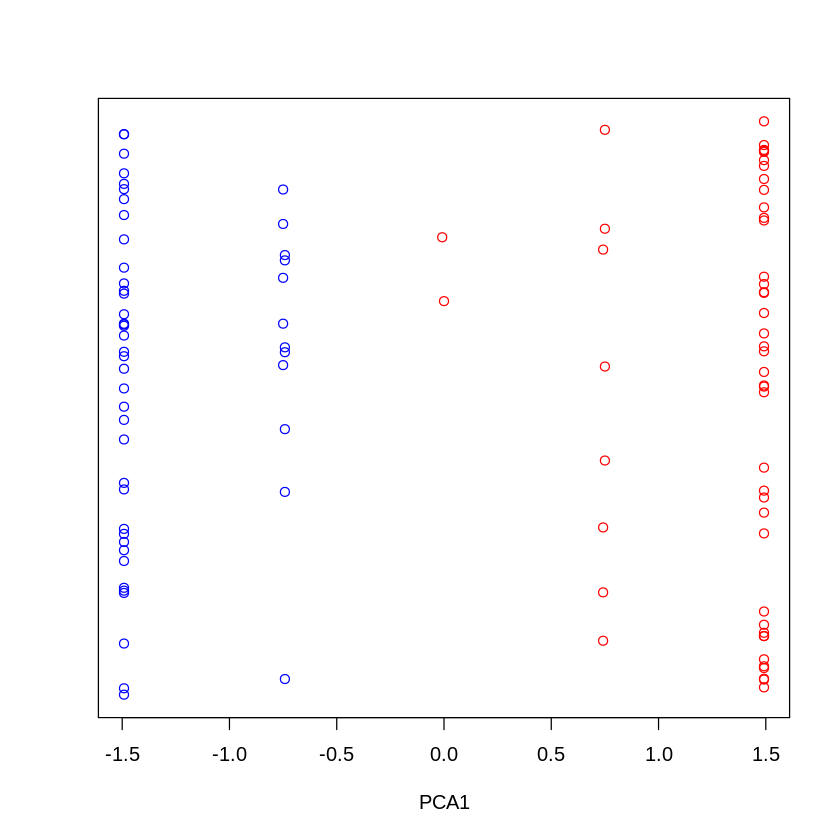

In [12]:
plot(pca$x[,1], runif(sum(n), -1, +1), col=cols[pop], yaxt="n", xlab="PCA1", ylab="")

##### Example 5.3

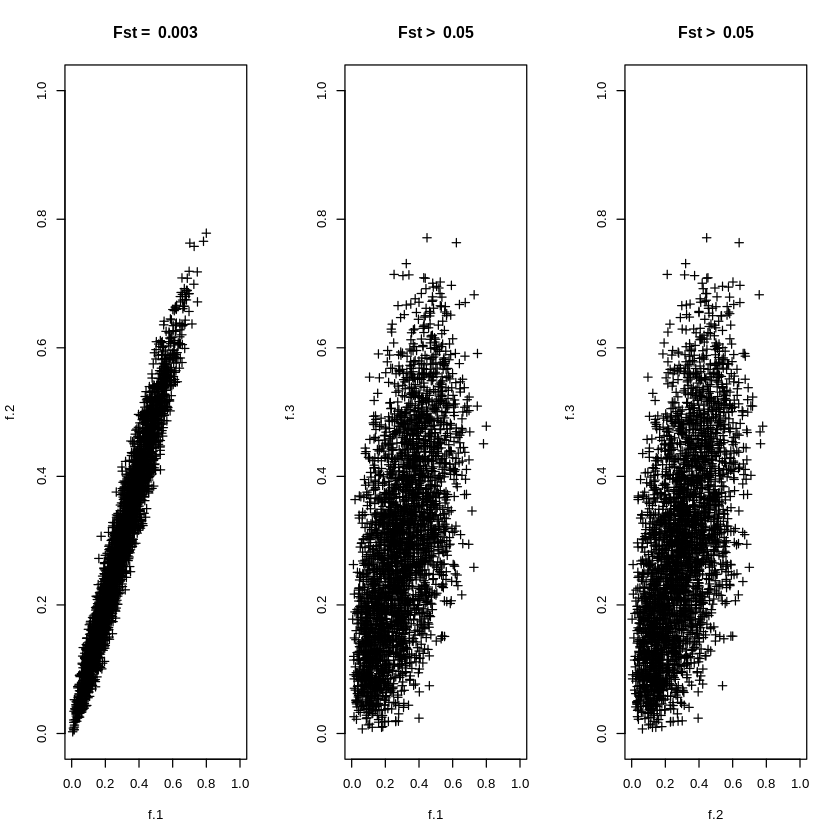

In [13]:
n = 100 # per population
p = 3000 # SNPs
fst.12 = 0.003
fst.12.3 = 0.05
f = runif(p, 0.10, 0.50) # common SNPs in background population
f.3 = rbeta(p, (1-fst.12.3)/fst.12.3*f, (1-fst.12.3)/fst.12.3*(1-f))
f.12 = rbeta(p, (1-fst.12.3)/fst.12.3*f, (1-fst.12.3)/fst.12.3*(1-f)) # P1 & P2's shared ancestor
f.1 = rbeta(p, (1-fst.12)/fst.12*f.12, (1-fst.12)/fst.12*(1-f.12))
f.2 = rbeta(p, (1-fst.12)/fst.12*f.12, (1-fst.12)/fst.12*(1-f.12))

# Let's check that f1 and f2 looks simillar compared to f.1 and f.3 or f.2 and f.3
par(mfrow=c(1, 3))
plot(f.1, f.2, main=paste("Fst = ", fst.12), xlim=c(0,1), ylim=c(0,1), pch=3)
plot(f.1, f.3, main=paste("Fst > ", fst.12.3), xlim=c(0,1), ylim=c(0,1), pch=3)
plot(f.2, f.3, main=paste("Fst > ", fst.12.3), xlim=c(0,1), ylim=c(0,1), pch=3)

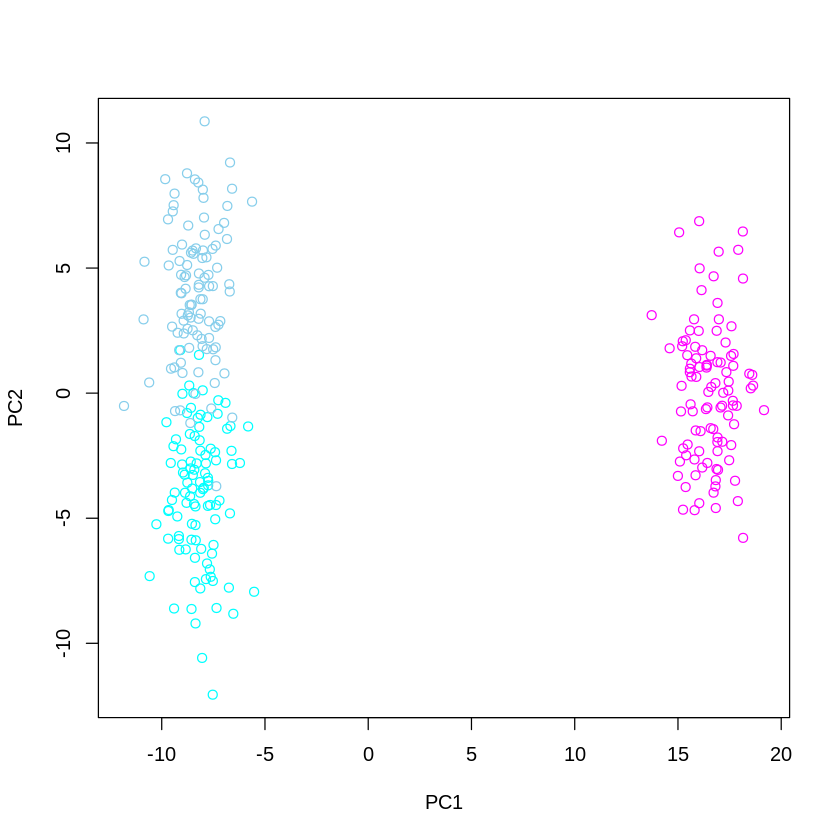

In [14]:
x = cbind(
    replicate(n, rbinom(p, size=2, p=f.1)), # generate n inds from P1
    replicate(n, rbinom(p, size=2, p=f.2)), # from P2
    replicate(n, rbinom(p, size=2, p=f.3))  # from P3
)
x = t(x) # each replicate (=ind) is now in a column, but we want inds to row and SNPs to cols
pca = prcomp(x, scale=T) # do PCA
cols = rep(c("cyan", "skyblue", "magenta"), each=n) # color for each ind accodrding to population
plot(pca$x[,1], pca$x[,2], col=cols, xlab="PC1", ylab="PC2")

##### Example 5.4

In [15]:
af = read.table("https://www.mv.helsinki.fi/home/mjxpirin/GWAS_course/material/afreq_1000G_phase1_chr15-22.txt",
               as.is=T, header=T)
dim(af)

[1] 5266   19

In [16]:
af[1,]

chr,id,position,a0,a1,ASW,CEU,CHB,CHS,CLM,FIN,GBR,IBS,JPT,LWK,MXL,PUR,TSI,YRI
15,rs11248847,20101049,G,A,0.2377,0.1882,0.4278,0.335,0.1917,0.1613,0.1461,0.2143,0.3876,0.2165,0.25,0.2091,0.1888,0.09659


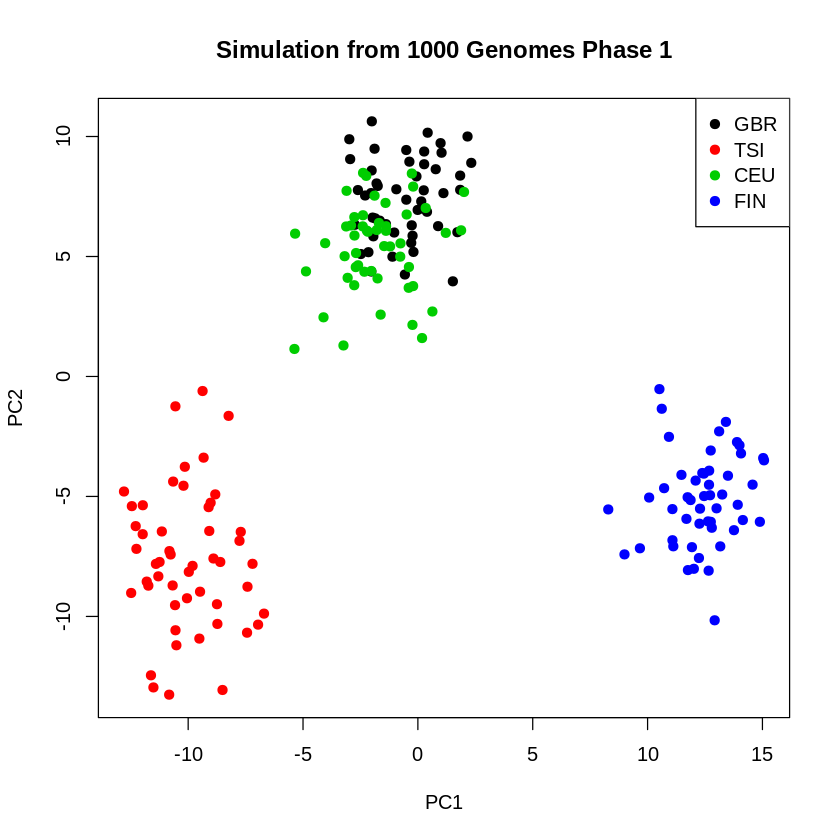

In [17]:
p = nrow(af) # number of SNPs
n = 50 # samples per population
pop.labs = c("GBR", "TSI", "CEU", "FIN")
pop = rep(1:length(pop.labs), each=n)
x = c()
for(ii in 1:length(pop.labs)) {
    x = rbind(x, t(replicate(n, rbinom(p, size=2, prob=af[,pop.labs[ii]]))))
}
x = x[, apply(x, 2, var) > 0] # remove monomorphic variants
pca = prcomp(x, scale=T)
plot(pca$x[,1], pca$x[,2], col=pop, pch=19, xlab="PC1", ylab="PC2",
    main="Simulation from 1000 Genomes Phase 1")
legend("topright", leg=pop.labs, col=1:length(pop.labs), pch=19, cex=1)

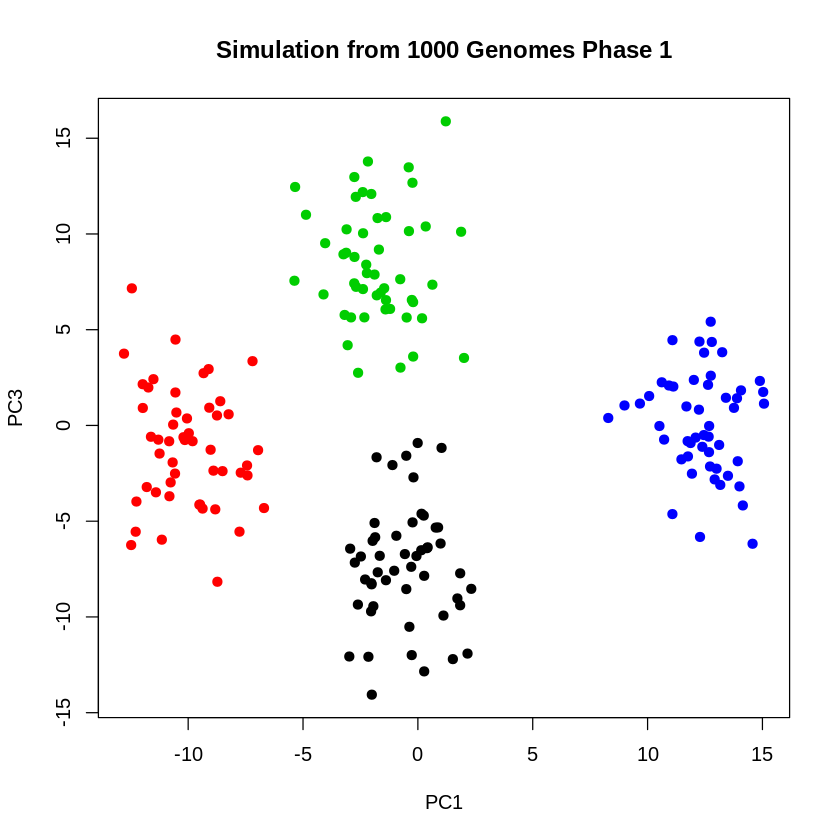

In [18]:
plot(pca$x[,1], pca$x[,3], col=pop, pch=19, xlab="PC1", ylab="PC3",
    main="Simulation from 1000 Genomes Phase 1")

##### Example 5.5

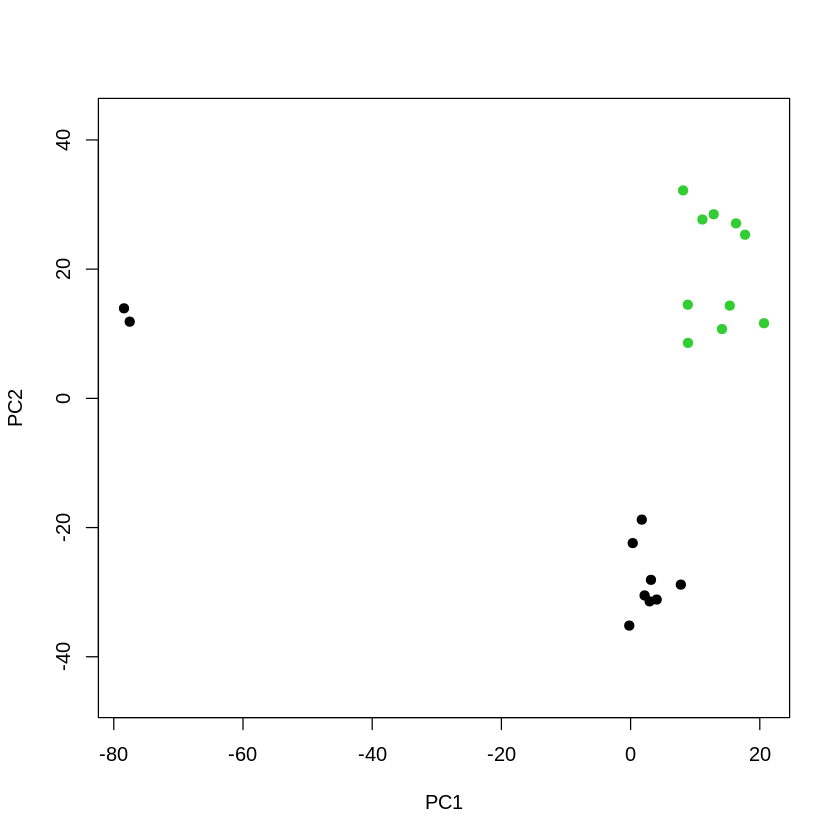

In [19]:
set.seed(20)
p = 10000 # SNPs
fst.12 = 0.01
cols = c("black", "limegreen")
f = runif(p, 0.20, 0.50) # common SNPs in background population
f.1 = rbeta(p, (1-fst.12)/fst.12*f, (1-fst.12)/fst.12*(1-f))
f.2 = rbeta(p, (1-fst.12)/fst.12*f, (1-fst.12)/fst.12*(1-f))

X = rbind(
    offspring.geno(n.families=1, n.snps=p, fs=f.1, n.shared.parents=2), # full sibs from 1
    offspring.geno(n.families=4, n.snps=p, fs=f.1, n.shared.parents=0), # unrel from 1
    offspring.geno(n.families=5, n.snps=p, fs=f.2, n.shared.parents=0) # unrel from 2
)
pop = c(rep(1, 2*5), rep(2, 2*5)) # population labels: 10x Pop1 and 10x Pop2

X = X[, apply(X, 2, var) > 0] # remove monomorphic variants before scaling
pca = prcomp(X, scale=T) # do PCA
plot(pca$x[,1], pca$x[,2], asp=1, col=cols[pop], xlab="PC1", ylab="PC2", pch=19)

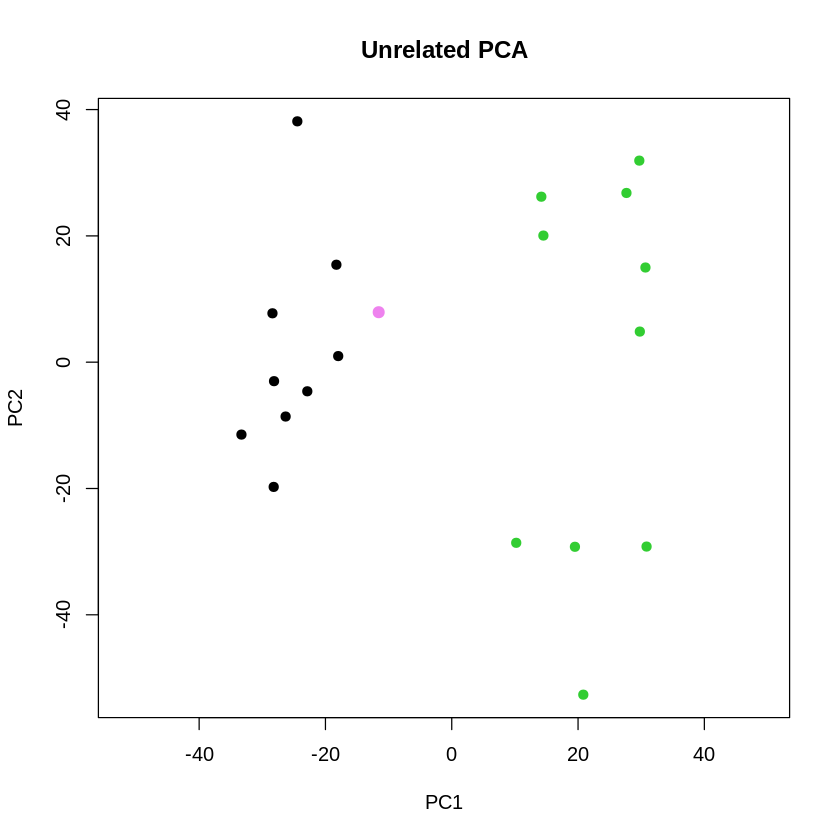

In [20]:
X.unrel = X[-1,] # remove row 1
pca = prcomp(X.unrel, scale=T)
plot(pca$x[,1], pca$x[,2], asp=1, col=cols[pop[-1]], xlab="PC1", ylab="PC2", main="Unrelated PCA", pch=19)
# project back individual 1 to the PCs spanned by the 19 other individuals
pca.1 = predict(pca, newdata=matrix(X[1,], nrow=1)) # projects new data to PCs defined in pca
points(pca.1[1], pca.1[2], col="violet", pch=19, cex=1.2) # ind 1 on PCs

### 5.2.3 Relatedness estimation with population structure

In [21]:
p = 10000 # SNPs
fst.12 = 0.1
f = runif(p, 0.20, 0.50) # common SNPs in background population
f.1 = rbeta(p, (1-fst.12)/fst.12*f, (1-fst.12)/fst.12*(1-f))
f.2 = rbeta(p, (1-fst.12)/fst.12*f, (1-fst.12)/fst.12*(1-f))

X = rbind(
    offspring.geno(n.families=4, n.snps=p, fs=f.1, n.shared.parents=1),
    offspring.geno(n.families=1, n.snps=p, fs=f.2, n.shared.parents=1)
)
X = X[, apply(X, 2, var) > 0] # remove monomorphic variants before scaling

# make GRM R
X.scaled = scale(X) # standardize each SNP at columns of X
GRM = (X.scaled %*% t(X.scaled)) / p # correlation matrix of inidividuals based on standardized SNPs

# make KING-robust estimate for r:
denominator = matrix(rep(rowSums(X==1), nrow(X)), nrow=nrow(X), byrow=T) + 
              matrix(rep(rowSums(X==1), nrow(X)), nrow=nrow(X), byrow=F)
king.r = 2 * ((X==1) %*% t(X==1) - 2 * ((X==0) %*% t(X==2) + (X==2) %*% t(X==0)) ) / denominator

[1] 0.10459466 0.09525122 0.09165326 0.09614190 0.29005345

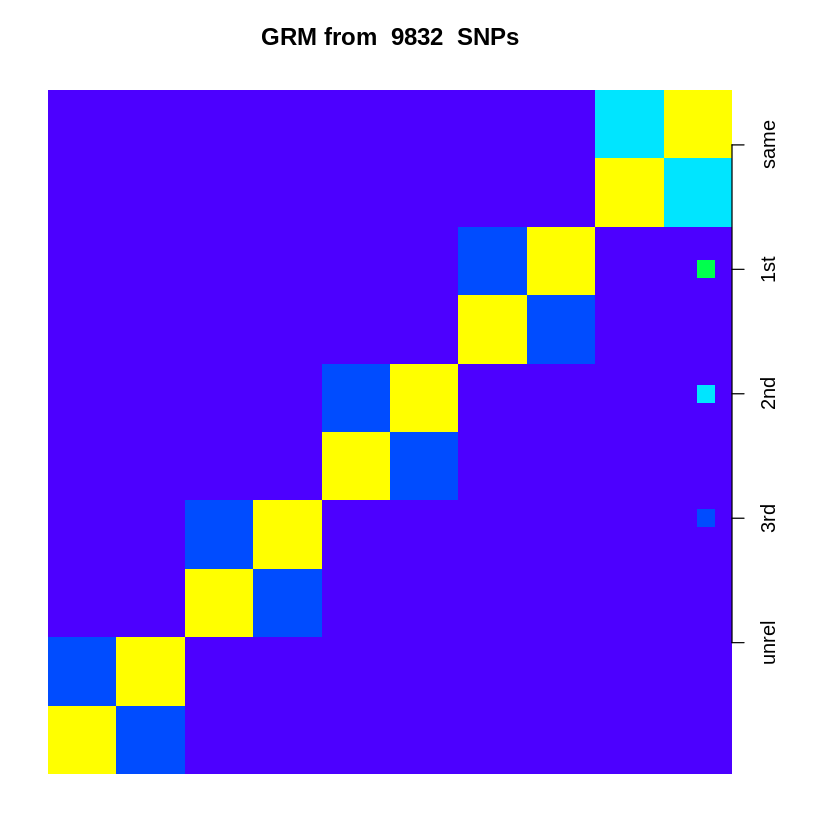

In [22]:
n.cols = 5 # make 5 categories of relatives
brk = c(-1, 0.088, 0.177, 0.354, 0.707, 1.5) # KING's breakpoints for unrelated, 3rd, 2nd, 1st, monozygotes
labs = c("unrel", "3rd", "2nd", "1st", "same")

layout(matrix(c(1, 2), nrow=1), width=c(9, 1)) # plotting area has matrix and color scale
par(mar = c(2, 2, 3, 1))
image(GRM, col=topo.colors(n.cols), breaks=brk,
      asp=1, xaxt="n", yaxt="n", bty="n",
      main=paste("GRM from ", ncol(X), " SNPs"))
par(mar=c(2, 1, 5, 1))
plot.window(xlim=c(0, 1), ylim=c(0, n.cols))
points(x=rep(1, n.cols), y=(1:n.cols), col=topo.colors(n.cols), pch=15, cex=2)
axis(4, at=1:n.cols, labels=labs)
c(GRM[1, 2], GRM[3, 4], GRM[5, 6], GRM[7, 8], GRM[9, 10]) # plot the relatedness values of half sibs

[1] 0.2458297 0.2454545 0.2482046 0.2511605 0.2443132

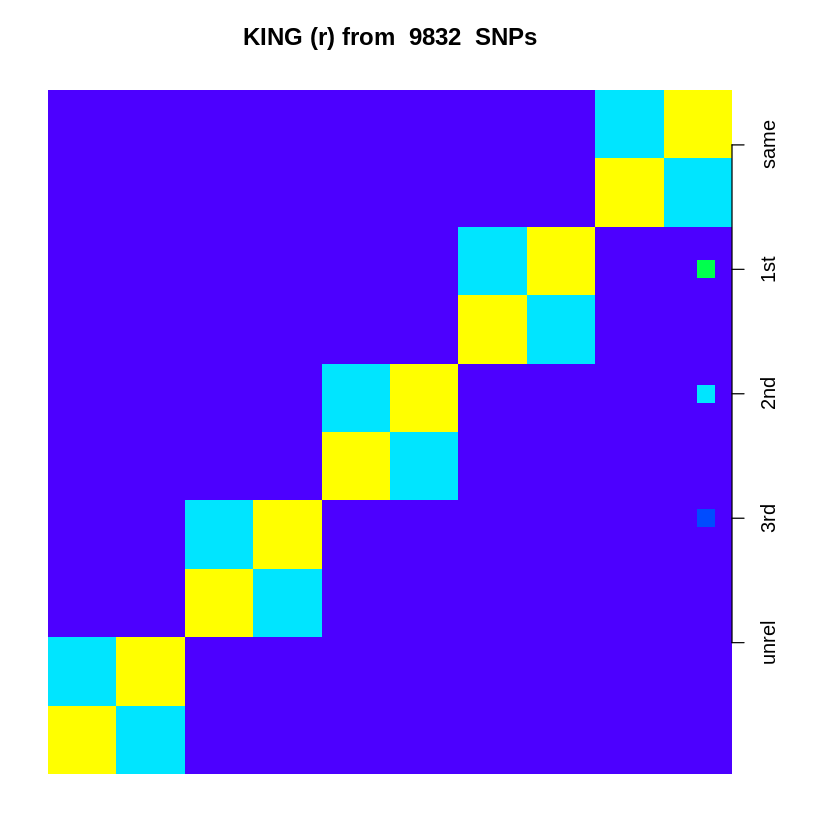

In [23]:
n.cols = 5 # make 5 categories of relatives
brk = c(-1, 0.088, 0.177, 0.354, 0.707, 1.5) # KING's breakpoints for unrelated, 3rd, 2nd, 1st, monozygotes
labs = c("unrel", "3rd", "2nd", "1st", "same")

layout(matrix(c(1, 2), nrow=1), width=c(9, 1)) # plotting area has matrix and color scale
par(mar = c(2, 2, 3, 1))
image(king.r, col=topo.colors(n.cols), breaks=brk,
      asp=1, xaxt="n", yaxt="n", bty="n",
      main=paste("KING (r) from ", ncol(X), " SNPs"))
par(mar=c(2, 1, 5, 1))
plot.window(xlim=c(0, 1), ylim=c(0, n.cols))
points(x=rep(1, n.cols), y=(1:n.cols), col=topo.colors(n.cols), pch=15, cex=2)
axis(4, at=1:n.cols, labels=labs)
c(king.r[1, 2], king.r[3, 4], king.r[5, 6], king.r[7, 8], king.r[9, 10]) # plot the relatedness values of half sibs